Task4 QSVM

In [17]:
pip install numpy==1.26.4

Note: you may need to restart the kernel to use updated packages.


In [18]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np



# Preprocessing the Iris Dataset



In [19]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Load Iris dataset
data = load_iris()

# Restrict to binary classification: Setosa (0) vs Versicolor (1)
X = data.data[data.target != 2][:, [2, 3]]  # Select petal length & petal width
y = data.target[data.target != 2]

# Normalize features to zero mean and unit variance
# This ensures stable rotation angles when encoding into quantum gates
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

Why this preprocessing?
- Dimensionality reduction to 2 features simplifies circuit design (2 qubits).
- Normalization avoids large rotation angles that could wrap around the Bloch sphere and distort encoding.


In [20]:
#  Feature Encoding Circuit
from qiskit import QuantumCircuit

def encode_features(x):
    # Encode each feature into a qubit using RY rotation
    # RY chosen for simplicity and interpretability (rotation around Y-axis)
    qc = QuantumCircuit(2)
    qc.ry(x[0], 0)
    qc.ry(x[1], 1)
    return qc




Why RY encoding?
- RY maps real-valued features to quantum states on the Bloch sphere.
- It's a common choice for angle encoding in variational circuits.


# Circuit Proposal 1 — Shallow Ansatz


In [21]:
def shallow_ansatz():
    # Simple 2-layer circuit with RY rotations and linear entanglement
    qc = QuantumCircuit(2)
    qc.ry(np.pi/4, 0)
    qc.ry(np.pi/4, 1)
    qc.cx(0, 1)  # Entangle qubit 0 with qubit 1
    qc.ry(np.pi/4, 0)
    qc.ry(np.pi/4, 1)
    return qc

Design Rationale
- Low depth = faster simulation and better noise resilience.
- Linear entanglement (one CNOT) captures basic correlations.
- Limited expressibility but good for linearly separable data.



# Circuit Proposal 2 — Deep Ansatz

In [22]:

def deep_ansatz():
    # Deeper circuit with multiple layers and full entanglement
    qc = QuantumCircuit(2)
    for _ in range(3):  # Repeat block to increase expressibility
        qc.rx(np.pi/4, 0)
        qc.ry(np.pi/4, 1)
        qc.cx(0, 1)
        qc.rx(np.pi/4, 1)
        qc.ry(np.pi/4, 0)
        qc.cx(1, 0)
    return qc




Design Rationale
- RX + RY increases rotational diversity (more directions on Bloch sphere).
- Full entanglement (bidirectional CNOTs) captures complex correlations.
- Higher expressibility but may suffer from barren plateaus or overfitting.

 # Evaluation Function




In [23]:
from qiskit.quantum_info import Statevector
from scipy.optimize import minimize

def evaluate_circuit(params, X, y, ansatz_fn):
    loss = 0
    for i in range(len(X)):
        # Encode features
        qc = encode_features(X[i])
        
        # Build ansatz and apply parameters
        ansatz = ansatz_fn()
        for j, param in enumerate(params):
            ansatz.ry(param, j % 2)  # Apply parameters cyclically to qubits
        
        # Combine encoding + ansatz
        qc.compose(ansatz, inplace=True)
        
        # Simulate circuit using statevector
        sv = Statevector.from_instruction(qc)
        prob_0 = sv.probabilities_dict().get('00', 0)
        
        # Binary prediction based on probability threshold
        pred = 0 if prob_0 > 0.5 else 1
        loss += (pred != y[i])
    
    return loss / len(X)  # Return classification error

Why Statevector simulation?
- Backend-free and noise-free.
- Ideal for evaluating expressibility and ideal performance.

#  Training with Classical Optimizer

In [24]:

# Initial parameters for optimization
init_params1 = np.random.rand(4)
init_params2 = np.random.rand(6)

# Train shallow circuit
res1 = minimize(evaluate_circuit, init_params1, args=(X_train, y_train, shallow_ansatz), method='COBYLA')

# Train deep circuit
res2 = minimize(evaluate_circuit, init_params2, args=(X_train, y_train, deep_ansatz), method='COBYLA')


Why COBYLA?
- Gradient-free optimizer suitable for noisy or non-differentiable landscapes.
- Works well for small parameter spaces.

# Accuracy Evaluation

In [25]:
acc1 = 1 - evaluate_circuit(res1.x, X_test, y_test, shallow_ansatz)
acc2 = 1 - evaluate_circuit(res2.x, X_test, y_test, deep_ansatz)

print(f"Shallow Circuit Accuracy: {acc1:.2f}")
print(f"Deep Circuit Accuracy: {acc2:.2f}")

Shallow Circuit Accuracy: 0.43
Deep Circuit Accuracy: 1.00


Comparison Criteria
- Accuracy: How well each circuit classifies unseen data.
- Depth vs performance: Shallow circuits may generalize better.
- Expressibility: Deep circuits can model complex boundaries.

# Decision Boundary Visualization

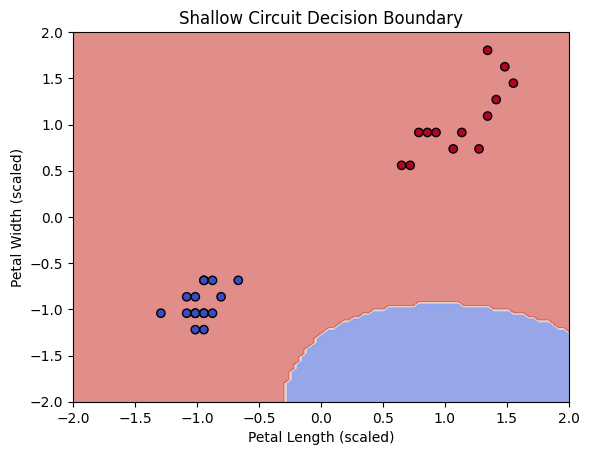

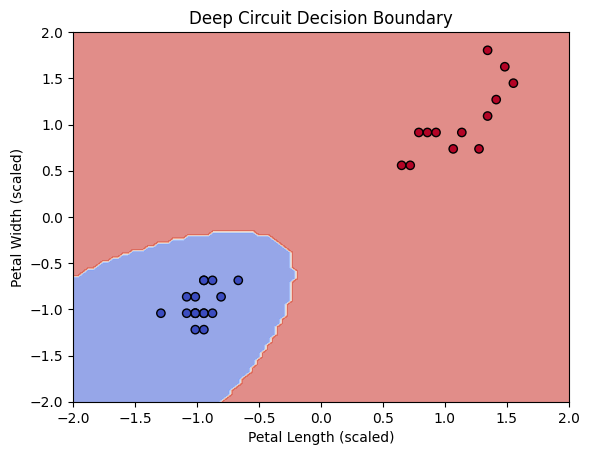

In [26]:
import matplotlib.pyplot as plt

# Create grid over feature space
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
grid = np.c_[xx.ravel(), yy.ravel()]

def predict_grid(params, grid, ansatz_fn):
    preds = []
    for x in grid:
        qc = encode_features(x)
        ansatz = ansatz_fn()
        for j, param in enumerate(params):
            ansatz.ry(param, j % 2)
        qc.compose(ansatz, inplace=True)
        sv = Statevector.from_instruction(qc)
        prob_0 = sv.probabilities_dict().get('00', 0)
        preds.append(0 if prob_0 > 0.5 else 1)
    return np.array(preds).reshape(xx.shape)

def plot_decision_boundary(params, ansatz_fn, title):
    Z = predict_grid(params, grid, ansatz_fn)
    plt.contourf(xx, yy, Z, alpha=0.6, cmap='coolwarm')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', cmap='coolwarm')
    plt.title(title)
    plt.xlabel("Petal Length (scaled)")
    plt.ylabel("Petal Width (scaled)")
    plt.show()

# Plot both circuits
plot_decision_boundary(res1.x, shallow_ansatz, "Shallow Circuit Decision Boundary")
plot_decision_boundary(res2.x, deep_ansatz, "Deep Circuit Decision Boundary")


Visual Insights
- Shallow circuit: Expect smoother, linear boundaries.
- Deep circuit: Expect curved or jagged boundaries, better fit to complex data.